#### Using TuneTA by pandas-ta

In [198]:
import os
from pathlib import Path


# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output
project_root = "/Users/liuqiaowei/SourceCode/freqtrade/user_data/notebooks"
i = 0
try:
    os.chdir(project_root)
    if not Path("LICENSE").is_file():
        i = 0
        while i < 4 and (not Path("LICENSE").is_file()):
            os.chdir(Path(Path.cwd(), "../"))
            i += 1
        project_root = Path.cwd()
except FileNotFoundError:
    print("Please define the project root relative to the current directory")
print(Path.cwd())

/Users/liuqiaowei/SourceCode/freqtrade


In [199]:
from freqtrade.configuration import Configuration


# Customize these according to your needs.

# Initialize empty configuration object
config = Configuration.from_files(["./user_data/config.json"])
# Optionally (recommended), use existing configuration file
# config = Configuration.from_files(["user_data/config.json"])

# Location of the data
data_location = config["datadir"]
config['timeframe'] = '1h'
# Pair to analyze - Only use one pair here
# config['exchange']['pair_whitelist']

In [200]:
from freqtrade.data.history import load_pair_history
from freqtrade.enums import CandleType
from pandas_ta import percent_return

candles_dict = {}
for pair in config['exchange']['pair_whitelist']:
    candles = load_pair_history(
        datadir=data_location,
        timeframe=config["timeframe"],
        pair=pair,
        data_format="feather",  # Make sure to update this to your data
        candle_type=CandleType.FUTURES,
    )
    candles['sym'] = pair
    candles.set_index('date', inplace=True)
    candles.set_index('sym', append=True, inplace=True)
    candles['return'] = percent_return(candles.close, offset=-1)
    # Keep Latest week for testing
    candles_dict[pair] = candles[-24*30:]

In [201]:
import pandas_ta as ta

ta.Category.keys()

dict_keys(['candles', 'cycles', 'momentum', 'overlap', 'performance', 'statistics', 'trend', 'volatility', 'volume'])

In [202]:
# Generate indicator names
from tuneta import config

target_categories = ['momentum', 'statistics', 'trend', 'volatility', 'volume']
exclude_indicators = ['stoch', 'tsignals', 'xsignals', 'pvr', 'tos_stdevall', 'ttm_trend']
indicator_names = []

for target_category in target_categories:
    indicators = ta.Category[target_category]
    for indicator in indicators:
        if indicator not in exclude_indicators:
            indicator_names.append(f'pta.{indicator}')

indicator_names.append('pta.supertrend')
len(indicator_names)

91

In [203]:
from tuneta.tune_ta import TuneTA
import pandas as pd

X = pd.concat([candles for _, candles in candles_dict.items()], axis=0).sort_index()
X.dropna(inplace=True)
y = X['return']
X = X.drop(columns=['return'])

In [204]:
X

open         high  \
date                      sym                                             
2024-10-25 09:00:00+00:00 1000FLOKI/USDT:USDT     0.143490     0.145280   
                          1000LUNC/USDT:USDT      0.091040     0.091330   
                          1000PEPE/USDT:USDT      0.009583     0.009677   
                          1000SHIB/USDT:USDT      0.017652     0.017770   
                          1000XEC/USDT:USDT       0.034050     0.034330   
...                                                    ...          ...   
2024-11-24 07:00:00+00:00 XTZ/USDT:USDT           1.400000     1.440000   
                          YFI/USDT:USDT        7541.000000  7548.000000   
                          ZEC/USDT:USDT          54.280000    54.870000   
                          ZIL/USDT:USDT           0.025490     0.025550   
                          ZRX/USDT:USDT           0.521200     0.535400   

                                                       low        close  \
date                      sym                                             
2024-10-25 09:00:00+00:00 1000FLOKI/USDT:USDT     0.143100     0.145210   
                          1000LUNC/USDT:USDT      0.090610     0.091320   
                          1000PEPE/USDT:USDT      0.009563     0.009676   
                          1000SHIB/USDT:USDT      0.017628     0.017761   
                          1000XEC/USDT:USDT       0.033990     0.034310   
...                                                    ...          ...   
2024-11-24 07:00:00+00:00 XTZ/USDT:USDT           1.399000     1.423000   
                          YFI/USDT:USDT        7419.000000  7496.000000   
                          ZEC/USDT:USDT          54.100000    54.530000   
                          ZIL/USDT:USDT           0.025160     0.025510   
                          ZRX/USDT:USDT           0.511900     0.512400   

                                                     volume  
date                      sym                                
2024-10-25 09:00:00+00:00 1000FLOKI/USDT:USDT  1.922966e+07  
                          1000LUNC/USDT:USDT   7.985970e+06  
                          1000PEPE/USDT:USDT   2.618233e+09  
                          1000SHIB/USDT:USDT   2.036946e+08  
                          1000XEC/USDT:USDT    2.291528e+06  
...                                                     ...  
2024-11-24 07:00:00+00:00 XTZ/USDT:USDT        8.155720e+06  
                          YFI/USDT:USDT        1.323280e+02  
                          ZEC/USDT:USDT        2.589598e+04  
                          ZIL/USDT:USDT        5.089615e+07  
                          ZRX/USDT:USDT        9.353089e+06  

[71900 rows x 5 columns]

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=False)

In [206]:
tt = TuneTA(n_jobs=4, verbose=True)

In [207]:
tt.fit(X_train, y_train,
        indicators=indicator_names,
        ranges=[(4, 12), (12, 24)],
        trials=30,
        early_stop=5,
)

tt.fit_times()

     Indicator          Times
---  ---------------  -------
 98  pta.amat          121.24
 91  pta.increasing    110.48
 31  pta.qqe            88.8
 93  pta.decreasing     88.56
131  pta.increasing     86.03
 26  pta.qqe            74.25
 54  pta.amat           51.99
129  pta.decreasing     50.51
 49  pta.stc            37.8
122  pta.supertrend     20.35
130  pta.stc            20.17
 41  pta.rvgi           16.93
158  pta.squeeze_pro    12.47
117  pta.supertrend     11.82
108  pta.accbands       11.03
157  pta.squeeze         9.22
 22  pta.ppo             9.18
 57  pta.kvo             9.17
 29  pta.adx             8.92
 28  pta.uo              8.68
 68  pta.stochrsi        8.62
159  pta.apo             8.54
 24  pta.cfo             8.4
 97  pta.adx             8.21
 92  pta.cti             8.14
121  pta.kc              7.91
 74  pta.fisher          7.82
167  pta.squeeze_pro     7.51
103  pta.bbands          7.28
  9  pta.bias            7.27
106  pta.quantile        7.25
 32  pta.tsi 

In [208]:
tt.report(target_corr=True, features_corr=False)


Indicator Correlation to Target:

                                                                                     Correlation
---------------------------------------------------------------------------------  -------------
pta_natr_length_16_mamode_fwma                                                          0.210127
pta_natr_length_10_mamode_dema                                                          0.208867
pta_pvi_length_7                                                                        0.161286
pta_pvi_length_19                                                                       0.155742
pta_nvi_length_19                                                                       0.149923
pta_nvi_length_9                                                                        0.132815
pta_ui_length_19                                                                        0.10843
pta_cfo_length_19                                                                       0.108

In [209]:
tt.prune(max_inter_correlation=.8)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [210]:
tt.report(target_corr=True, features_corr=True)


Indicator Correlation to Target:

                                                            Correlation
--------------------------------------------------------  -------------
pta_natr_length_16_mamode_fwma                                 0.210127
pta_pvi_length_7                                               0.161286
pta_ui_length_19                                               0.10843
pta_ui_length_9                                                0.10745
pta_bias_length_14_mamode_trima                                0.101792
pta_bias_length_10_mamode_dema                                 0.096811
pta_coppock_length_22_fast_17_slow_18                          0.093487
pta_roc_length_19                                              0.092823
pta_entropy_length_8                                           0.091081
pta_cfo_length_9                                               0.080032
pta_pvo_fast_17_slow_15_signal_19                              0.073183
pta_uo_fast_21_medium_19_slow_2

In [211]:
indicators_corr_df =  tt.t_corr[tt.t_corr['Correlation'] > 0.03]
indicators_corr_df

,Correlation
pta_natr_length_16_mamode_fwma,0.210127
pta_pvi_length_7,0.161286
pta_ui_length_19,0.108430
pta_ui_length_9,0.107450
pta_bias_length_14_mamode_trima,0.101792
pta_bias_length_10_mamode_dema,0.096811
pta_coppock_length_22_fast_17_slow_18,0.093487
pta_roc_length_19,0.092823
pta_entropy_length_8,0.091081
pta_cfo_length_9,0.080032


In [212]:
indicator_with_params_list = indicators_corr_df.index.to_list()
indicator_with_params_list

['pta_natr_length_16_mamode_fwma',
 'pta_pvi_length_7',
 'pta_ui_length_19',
 'pta_ui_length_9',
 'pta_bias_length_14_mamode_trima',
 'pta_bias_length_10_mamode_dema',
 'pta_coppock_length_22_fast_17_slow_18',
 'pta_roc_length_19',
 'pta_entropy_length_8',
 'pta_cfo_length_9',
 'pta_pvo_fast_17_slow_15_signal_19',
 'pta_uo_fast_21_medium_19_slow_21',
 'pta_adx_length_5_lensig_10_mamode_trima',
 'pta_adosc_fast_19_slow_21',
 'pta_skew_length_19',
 'pta_stochrsi_length_7_rsi_length_6_k_11_d_7_mamode_pwma',
 'pta_massi_fast_19_slow_21',
 'pta_chop_length_16_atr_length_24',
 'pta_stc_tclength_23_fast_21_slow_22',
 'pta_efi_length_8_mamode_dema',
 'pta_skew_length_9',
 'pta_kvo_fast_14_slow_12_signal_16_mamode_swma',
 'pta_chop_length_7_atr_length_12',
 'pta_massi_fast_9_slow_10',
 'pta_ad',
 'pta_bop',
 'pta_kvo_fast_10_slow_7_signal_5_mamode_swma',
 'pta_stochrsi_length_19_rsi_length_13_k_15_d_16_mamode_t3',
 'pta_pvo_fast_7_slow_6_signal_9',
 'pta_fisher_length_21_signal_16',
 'pta_psl_l

In [213]:
def generate_function_eval_string(indicator_params_str: str) -> str:
    indicator_params_list = indicator_params_str.split('_')
    first_param_name = ''
    
    for i, v in enumerate(indicator_params_list):
        if v.isdigit():
            first_param_name = indicator_params_list[i-1]
            break
        elif v == 'mamode':
            first_param_name = indicator_params_list[i]
            break
            
    if first_param_name == '':
        return f'ta.{indicator_params_str[4:]}()'
            
    indicator_name = indicator_params_str[4:indicator_params_str.index(first_param_name)-1]
    indicator_params = indicator_params_str[indicator_params_str.index(first_param_name):]
    
    indicator_params_list = indicator_params.split('_')
    indicator_params_str = ''
    
    for i, indicator_param in enumerate(indicator_params_list):
        indicator_params_str += indicator_param
        if indicator_param.isdigit():
            indicator_params_str += ','
        elif i < len(indicator_params_list) - 1 and indicator_params_list[i+1] in ['length', 'lookback']:
            indicator_params_str += '_'
        elif indicator_param not in ['mamode', 'sma1', 'sma2', 'sma3', 'sma4'] and 'ma' in indicator_param:
            indicator_params_str += ','
        else:
            indicator_params_str += '='
    indicator_params_str = indicator_params_str[:-1]
    
    if 'mamode=' in indicator_params_str:
        mamode_index = indicator_params_str.index('mamode')
        mamode_value = indicator_params_str[mamode_index+7:]
        indicator_params_str = str.replace(indicator_params_str, mamode_value, f"'{mamode_value}'")
    
    return f'ta.{indicator_name}({indicator_params_str})'

In [214]:
# Dynamic calculate indicators
import pandas_ta as ta
factors_df_dict = {}
pta_function_factors_dict = {}
open_df = pd.DataFrame()

# indicator_with_params_list.remove('pta_tos_stdevall_length_7_ddof_7')

for key, value in candles_dict.items():
    candles = value.copy()
    candles.reset_index(inplace=True)
    candles.set_index(['date'], inplace=True)
    if len(factors_df_dict.keys()) == 0:
        open_df_temp = candles['open'].to_frame()
        open_df_temp.columns = [key]
        open_df = open_df_temp
        for indicator_with_params in indicator_with_params_list:
            eval_string = generate_function_eval_string(indicator_with_params)
            print(eval_string)
            eval_result = eval(f'candles.{eval_string}')
            if type(eval_result) == pd.Series:
                eval_result = eval_result.to_frame()
            factors_names = eval_result.columns.tolist()
            for factor_name in factors_names:
                pta_function_factors_dict[factor_name] = indicator_with_params
            for factor_name in factors_names:
                single_factor = eval_result[factor_name].to_frame()
                single_factor.columns = [key]
                factors_df_dict[factor_name] = single_factor
    else:
        open_df_temp = candles['open'].to_frame()
        open_df_temp.columns = [key]
        open_df = open_df.join(open_df_temp)
        for indicator_with_params in indicator_with_params_list:
            eval_string = generate_function_eval_string(indicator_with_params)
            eval_result = eval(f'candles.{eval_string}')
            if type(eval_result) == pd.Series:
                eval_result = eval_result.to_frame()
            factors_names = eval_result.columns.tolist()
            for factor_name in factors_names:
                single_factor = eval_result[factor_name].to_frame()
                single_factor.columns = [key]
                factors_df_dict[factor_name] = factors_df_dict[factor_name].join(single_factor)
                
pta_function_factors_dict

ta.natr(length=16,mamode='fwma')
ta.pvi(length=7)
ta.ui(length=19)
ta.ui(length=9)
ta.bias(length=14,mamode='trima')
ta.bias(length=10,mamode='dema')
ta.coppock(length=22,fast=17,slow=18)
ta.roc(length=19)
ta.entropy(length=8)
ta.cfo(length=9)
ta.pvo(fast=17,slow=15,signal=19)
ta.uo(fast=21,medium=19,slow=21)
ta.adx(length=5,lensig=10,mamode='trima')
ta.adosc(fast=19,slow=21)
ta.skew(length=19)
ta.stochrsi(length=7,rsi_length=6,k=11,d=7,mamode='pwma')
ta.massi(fast=19,slow=21)
ta.chop(length=16,atr_length=24)
ta.stc(tclength=23,fast=21,slow=22)
ta.efi(length=8,mamode='dema')
ta.skew(length=9)
ta.kvo(fast=14,slow=12,signal=16,mamode='swma')
ta.chop(length=7,atr_length=12)
ta.massi(fast=9,slow=10)
ta.ad()
ta.bop()
ta.kvo(fast=10,slow=7,signal=5,mamode='swma')
ta.stochrsi(length=19,rsi_length=13,k=15,d=16,mamode='t3')
ta.pvo(fast=7,slow=6,signal=9)
ta.fisher(length=21,signal=16)
ta.psl(length=19)
ta.fisher(length=6,signal=8)
ta.aroon(length=19)
ta.uo(fast=7,medium=6,slow=9)
ta.pvol()
ta.i

{'NATR_16': 'pta_natr_length_16_mamode_fwma',
 'PVI_7': 'pta_pvi_length_7',
 'UI_19': 'pta_ui_length_19',
 'UI_9': 'pta_ui_length_9',
 'BIAS_TRIMA_14': 'pta_bias_length_14_mamode_trima',
 'BIAS_DEMA_10': 'pta_bias_length_10_mamode_dema',
 'COPC_17_18_22': 'pta_coppock_length_22_fast_17_slow_18',
 'ROC_19': 'pta_roc_length_19',
 'ENTP_8': 'pta_entropy_length_8',
 'CFO_9': 'pta_cfo_length_9',
 'PVO_15_17_19': 'pta_pvo_fast_17_slow_15_signal_19',
 'PVOh_15_17_19': 'pta_pvo_fast_17_slow_15_signal_19',
 'PVOs_15_17_19': 'pta_pvo_fast_17_slow_15_signal_19',
 'UO_21_19_21': 'pta_uo_fast_21_medium_19_slow_21',
 'ADX_10': 'pta_adx_length_5_lensig_10_mamode_trima',
 'DMP_5': 'pta_adx_length_5_lensig_10_mamode_trima',
 'DMN_5': 'pta_adx_length_5_lensig_10_mamode_trima',
 'ADOSC_19_21': 'pta_adosc_fast_19_slow_21',
 'SKEW_19': 'pta_skew_length_19',
 'STOCHRSIk_7_6_11_7': 'pta_stochrsi_length_7_rsi_length_6_k_11_d_7_mamode_pwma',
 'STOCHRSId_7_6_11_7': 'pta_stochrsi_length_7_rsi_length_6_k_11_d_7_m

In [215]:
from user_data.notebooks.factor_analysis_helper import standardize

# Standardize Factor

standardized_factors_df_dict = {}
for key in factors_df_dict.keys():
    standardized_factors_df_dict[key] = standardize(factors_df_dict[key])

standardized_factors_df_dict.keys()

dict_keys(['NATR_16', 'PVI_7', 'UI_19', 'UI_9', 'BIAS_TRIMA_14', 'BIAS_DEMA_10', 'COPC_17_18_22', 'ROC_19', 'ENTP_8', 'CFO_9', 'PVO_15_17_19', 'PVOh_15_17_19', 'PVOs_15_17_19', 'UO_21_19_21', 'ADX_10', 'DMP_5', 'DMN_5', 'ADOSC_19_21', 'SKEW_19', 'STOCHRSIk_7_6_11_7', 'STOCHRSId_7_6_11_7', 'MASSI_19_21', 'CHOP_16_24_100', 'STC_23_21_22_0.5', 'STCmacd_23_21_22_0.5', 'STCstoch_23_21_22_0.5', 'EFI_8', 'SKEW_9', 'KVO_14_12_16', 'KVOs_14_12_16', 'CHOP_7_12_100', 'MASSI_9_10', 'AD', 'BOP', 'KVO_10_7_5', 'KVOs_10_7_5', 'STOCHRSIk_19_13_15_16', 'STOCHRSId_19_13_15_16', 'PVO_6_7_9', 'PVOh_6_7_9', 'PVOs_6_7_9', 'FISHERT_21_16', 'FISHERTs_21_16', 'PSL_19', 'FISHERT_6_8', 'FISHERTs_6_8', 'AROOND_19', 'AROONU_19', 'AROONOSC_19', 'UO_7_6_9', 'PVOL', 'INC_16', 'AROOND_9', 'AROONU_9', 'AROONOSC_9', 'VHF_7', 'ADX_13', 'DMP_16', 'DMN_16', 'AMATt_LR_6_9_5', 'AMATt_SR_6_9_5', 'BBL_14_2.0', 'BBM_14_2.0', 'BBU_14_2.0', 'BBB_14_2.0', 'BBP_14_2.0', 'ER_19', 'ER_9', 'DEC_9', 'STC_7_6_9_0.5', 'STCmacd_7_6_9_0.5'

In [216]:
from user_data.notebooks.factor_analysis_helper import Quick_Factor_Return_N_IC

# IC IR Checking
factor_icir_result = {}
factors_icir_report_dict = {}
icir_factors_list = []

for key in standardized_factors_df_dict.keys():
    factor_icir_result[key], factors_icir_report_dict[key] = Quick_Factor_Return_N_IC(standardized_factors_df_dict[key], open_df, 1, key, '1h')
    # if 'TOS_STDEVALL' in key:
    #     continue
    if abs(factors_icir_report_dict[key]['IC mean']) > 0.02 or abs(factors_icir_report_dict[key]['IR']) > 0.2:
        icir_factors_list.append(key)

icir_factors_list
        

['NATR_16',
 'BIAS_TRIMA_14',
 'BIAS_DEMA_10',
 'ROC_19',
 'ENTP_8',
 'CFO_9',
 'DMP_5',
 'DMN_5',
 'EFI_8',
 'BOP',
 'AROONOSC_19',
 'DMP_16',
 'DMN_16',
 'BBP_14_2.0']

In [217]:
factor_ic_map = {}
for key, value in factors_icir_report_dict.items():
    if key in icir_factors_list:
        factor_ic_map[key] = value['IC mean']

factor_ic_map

{'NATR_16': -0.0283,
 'BIAS_TRIMA_14': -0.0445,
 'BIAS_DEMA_10': -0.0527,
 'ROC_19': -0.0296,
 'ENTP_8': -0.0202,
 'CFO_9': -0.0485,
 'DMP_5': -0.0219,
 'DMN_5': 0.0249,
 'EFI_8': -0.0422,
 'BOP': -0.0442,
 'AROONOSC_19': -0.0202,
 'DMP_16': -0.0297,
 'DMN_16': 0.0296,
 'BBP_14_2.0': -0.0438}

In [218]:
# from user_data.notebooks.factor_analysis_helper import Factor_Group_Analysis
# 
# # Group Analysis
# group_weekly_ret_dict = {}
# group_corr_dict = {}
# group_factors_list = []
# group_factors = []
# 
# for key in icir_factors_list:
#     print('---')
#     print(f'{key}')
#     print('---')
#     # if key == 'TTM_TRND_9':
#     #     continue
#     try:
#         group_weekly_ret_dict[key], group_corr_dict[key] = Factor_Group_Analysis(standardized_factors_df_dict[key].dropna(), open_df, 5, 1, key)
#     except Exception as e:
#         continue
#     print(group_weekly_ret_dict[key])
#     print(group_corr_dict[key])
#     if abs(group_corr_dict[key]) >= 0.5:
#         group_factors.append(key)
#     
# group_factors

---
NATR_16
---
 当前：702 / 总量：704    weekly_ret  group
G1   -0.029871      1
G2   -0.000274      2
G3    0.011686      3
G4    0.007438      4
G5    0.008529      5
0.7
---
BIAS_TRIMA_14
---
 当前：705 / 总量：707    weekly_ret  group
G1    0.006143      1
G2    0.001845      2
G3    0.005809      3
G4   -0.011908      4
G5   -0.004232      5
-0.8
---
BIAS_DEMA_10
---
 当前：680 / 总量：702

KeyboardInterrupt: 

In [219]:
# Try Combine
combine_factor_df = pd.DataFrame()

for key in icir_factors_list:
    ic = factors_icir_report_dict[key]['IC mean']
    if combine_factor_df.shape[0] == 0:
        combine_factor_df = standardized_factors_df_dict[key] * (-1 if ic < 0 else 1)
    else:
        combine_factor_df = combine_factor_df + (standardized_factors_df_dict[key] * (-1 if ic < 0 else 1))

combine_factor_df.iloc[-1].sort_values()

SAND/USDT:USDT       -35.406770
MANA/USDT:USDT       -25.607099
ENJ/USDT:USDT        -22.337916
LRC/USDT:USDT        -20.181583
XTZ/USDT:USDT        -20.089511
                        ...    
XRP/USDT:USDT         10.854752
ETC/USDT:USDT         11.602680
1000PEPE/USDT:USDT    11.860219
SOL/USDT:USDT         12.058536
DOGE/USDT:USDT        14.327546
Name: 2024-11-24 08:00:00+00:00, Length: 100, dtype: float64

In [220]:
ic_result, report = Quick_Factor_Return_N_IC(combine_factor_df, open_df, 1, 'combo', '1h')

report

{'name': 'combo',
 'time frame': '1h',
 'IC mean': 0.0543,
 'IC std': 0.1641,
 'IR': 0.3311,
 'IC>0': 0.6521,
 'ABS_IC>2%': 0.8981}

<Axes: title={'center': 'CUM_IC'}, xlabel='date'>

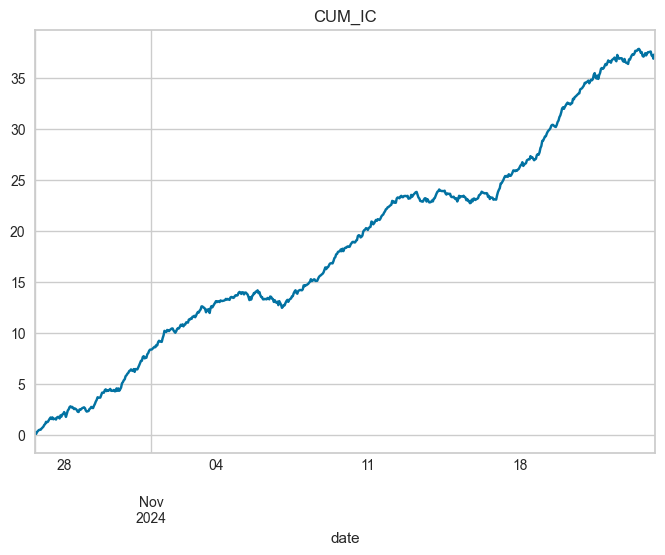

In [221]:
ic_result.cumsum().plot(title = 'CUM_IC')

<Axes: title={'center': 'IC_DAILY'}, xlabel='date'>

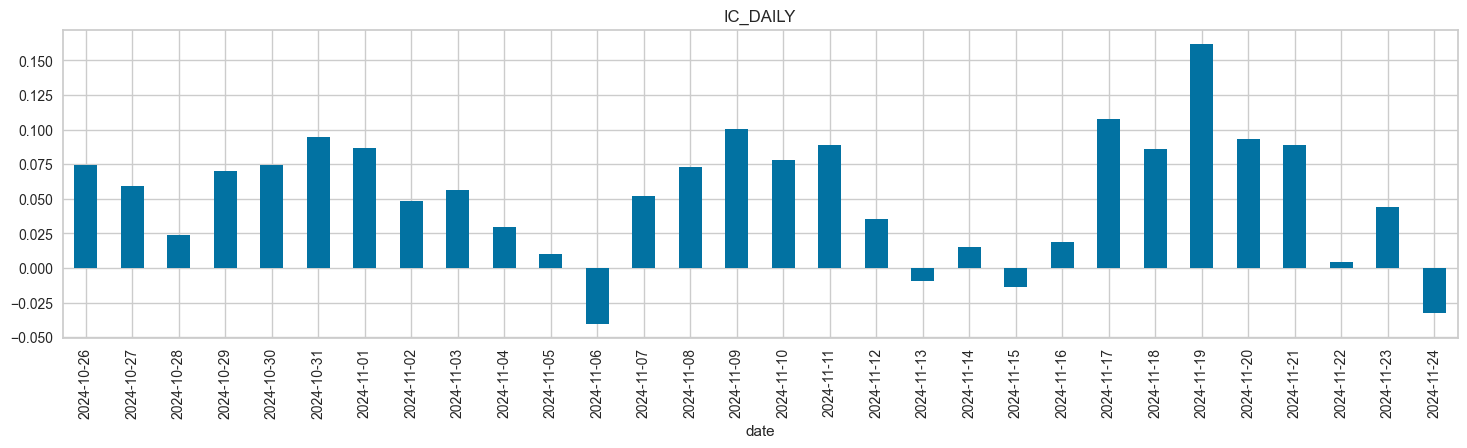

In [222]:
ic_day = ic_result.resample('D').mean()
ic_day.index = ic_day.index.strftime("%F")
ic_day.plot(kind = 'bar',figsize=(18,4),title = 'IC_DAILY')

In [223]:
from user_data.notebooks.factor_analysis_helper import Factor_Group_Analysis

Factor_Group_Analysis(combine_factor_df.dropna(), open_df, 5, 1, '')

 当前：687 / 总量：689

(    weekly_ret  group
 G1   -0.025973      1
 G2   -0.011430      2
 G3    0.001406      3
 G4    0.012698      4
 G5    0.021617      5,
 1.0)

In [224]:
combine_factor_df.iloc[-1].sort_values()

SAND/USDT:USDT       -35.406770
MANA/USDT:USDT       -25.607099
ENJ/USDT:USDT        -22.337916
LRC/USDT:USDT        -20.181583
XTZ/USDT:USDT        -20.089511
                        ...    
XRP/USDT:USDT         10.854752
ETC/USDT:USDT         11.602680
1000PEPE/USDT:USDT    11.860219
SOL/USDT:USDT         12.058536
DOGE/USDT:USDT        14.327546
Name: 2024-11-24 08:00:00+00:00, Length: 100, dtype: float64

In [225]:
final_factors = icir_factors_list
final_pta_indicators_with_parameters = set()

# Find pta indicator parameters
for final_factor in final_factors:
    final_pta_indicators_with_parameters.add(pta_function_factors_dict[final_factor])

final_pta_indicators_with_parameters

{'pta_adx_length_16_lensig_13_mamode_dema',
 'pta_adx_length_5_lensig_10_mamode_trima',
 'pta_aroon_length_19',
 'pta_bbands_length_14_ddof_20_mamode_fwma',
 'pta_bias_length_10_mamode_dema',
 'pta_bias_length_14_mamode_trima',
 'pta_bop',
 'pta_cfo_length_9',
 'pta_efi_length_8_mamode_dema',
 'pta_entropy_length_8',
 'pta_natr_length_16_mamode_fwma',
 'pta_roc_length_19'}

In [227]:
factor_ic_map

{'NATR_16': -0.0283,
 'BIAS_TRIMA_14': -0.0445,
 'BIAS_DEMA_10': -0.0527,
 'ROC_19': -0.0296,
 'ENTP_8': -0.0202,
 'CFO_9': -0.0485,
 'DMP_5': -0.0219,
 'DMN_5': 0.0249,
 'EFI_8': -0.0422,
 'BOP': -0.0442,
 'AROONOSC_19': -0.0202,
 'DMP_16': -0.0297,
 'DMN_16': 0.0296,
 'BBP_14_2.0': -0.0438}